In [1]:
import pickle
import pumpp
import numpy as np
import librosa
import os
from glob import glob

import tensorflow as tf
import keras as K
import pescador
import pandas as pd

import jams
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GroupShuffleSplit

Using TensorFlow backend.


In [2]:
SEED = 20170401

In [3]:
DATA_DIR = '/home/bmcfee/working/chords/pump'

In [4]:
# Reload the pump
with open('/home/bmcfee/working/chords/pump.pkl', 'rb') as fd:
    pump = pickle.load(fd)

In [5]:
# Calculate the number of frames

MAX_SAMPLES = 128

duration = 8.0

pump['cqt'].sr

n_frames = librosa.time_to_frames(duration,
                                  sr=pump['cqt'].sr,
                                  hop_length=pump['cqt'].hop_length)[0]

sampler = pump.sampler(MAX_SAMPLES, n_frames, random_state=SEED)

In [6]:
n_frames

86

In [7]:
def data_sampler(fname, sampler):

    data = np.load(fname)
    d2 = dict(data)
    data.close()
    data = d2
    
    yield from sampler(data)

In [8]:
def data_generator(tracks, sampler, k, batch_size=16, augmentation=False, weights=None, **kwargs):
    
    seeds = []
    pool_weights = []
    
    for track in tracks:
        
        fname = os.path.join(DATA_DIR, os.path.extsep.join([track, 'npz']))
        seeds.append(pescador.Streamer(data_sampler, fname, sampler))
        
        if weights is not None:
            pool_weights.append(weights.loc[track])
            
        if augmentation:
            for fname in sorted(glob(os.path.join(DATA_DIR, '{}.*.npz'.format(track)))):
                seeds.append(pescador.Streamer(data_sampler, fname, sampler))
                if weights is not None:
                    pool_weights.append(weights.loc[track])
        
    # Send it all to a mux
    if not pool_weights:
        pool_weights = None
        
    mux = pescador.Mux(seeds, k, pool_weights=pool_weights, **kwargs)
    
    if batch_size == 1:
        return mux
    else:
        return pescador.BufferedStreamer(mux, batch_size)

In [9]:
def wrap(gen):
    
    for batch in gen:
        yield [batch[0], batch[1]], list(batch[2:])

In [10]:
from collections import defaultdict
import mir_eval

def estimate_class_annotation(ann, op, quality_only):
    
    weights = defaultdict(lambda : 0.0)
    
    intervals, values = ann.data.to_interval_values()
    
    for ival, chord in zip(intervals, values):
        chord = op.simplify(chord)
        
        if quality_only:
            chord = reduce_chord(chord)
            
        weights[chord] += ival[1] - ival[0]
    
    return weights, np.max(intervals)
    
def reduce_chord(c):
    
    if ':' in c:
        return c[c.rindex(':')+1:]
    else:
        return c

def estimate_class_weights(tracks, op, pseudo=1e-2, quality_only=True,
                           refs='/home/bmcfee/data/eric_chords/references_v2/'):
    
    seeds = [os.path.join(refs, os.path.extsep.join([track, 'jams'])) for track in tracks]
    
    vocab = op.vocabulary()
    
    if quality_only:
        vocab = set([reduce_chord(c) for c in vocab])
        
    weights = {k: pseudo for k in vocab}
    
    total = 0.0
    
    for jam_in in tqdm(seeds):
        jam = jams.load(jam_in, validate=False)
        for ann in jam.annotations['chord']:
            weights_i, duration_i = estimate_class_annotation(ann, op, quality_only)
            total += duration_i
            for k in weights_i:
                weights[k] += weights_i[k]

    for k in weights:
        weights[k] /= total
    
    return weights

def weight_track(track, class_weights, op, quality_only=True, refs='/home/bmcfee/data/eric_chords/references_v2/',
                 aggregate=np.max, temporal=True):
    
    weights = 0
    jam_in = os.path.join(refs, os.path.extsep.join([track, 'jams']))
    jam = jams.load(jam_in, validate=False)
    
    weight = []
    for ann in jam.annotations['chord']:
        weights_i, duration_i = estimate_class_annotation(ann, op, quality_only)
        
        phat = 0.0
        for k in weights_i:
            if temporal:
                phat += weights_i[k] / duration * np.log(class_weights[k])
            else:
                phat += np.log(class_weights[k]) / len(weights_i)
                
        weight.append(np.exp(-phat))
        
    return aggregate(weight)

def weight_tracks(tracks, *args, **kwargs):
    
    weights = {}
    for track in tqdm(tracks):
        weights[track] = weight_track(track, *args, **kwargs)
        
    return pd.Series(data=weights)

# Construct the model

In [11]:
pump.fields

{'chord_struct/bass': Tensor(shape=(None, 1), dtype=<class 'int'>),
 'chord_struct/pitch': Tensor(shape=(None, 12), dtype=<class 'bool'>),
 'chord_struct/root': Tensor(shape=(None, 1), dtype=<class 'int'>),
 'chord_tag/chord': Tensor(shape=(None, 1), dtype=<class 'int'>),
 'cqt/mag': Tensor(shape=(None, 216, 1), dtype=<class 'numpy.float32'>)}

In [12]:
len(pump['chord_tag'].vocabulary())

170

In [13]:
pump['cqt'].layers()

{'cqt/mag': <tf.Tensor 'cqt/mag:0' shape=(?, ?, 216, 1) dtype=float32>}

In [14]:
LAYERS = pump['cqt'].layers()

x = LAYERS['cqt/mag']

b = K.layers.BatchNormalization()(x)

c0 = K.layers.Convolution2D(1, (5, 5), padding='same',
                            activation='relu',
                            data_format='channels_last')(b)

c1 = K.layers.Convolution2D(36, (1, int(c0.shape[2])), padding='valid', activation='relu',
                            data_format='channels_last')(c0)

r1 = K.layers.Lambda(lambda x: K.backend.squeeze(x, axis=2))(c1)

rs = K.layers.Bidirectional(K.layers.GRU(64, return_sequences=True))(r1)

p0 = K.layers.Dense(len(pump['chord_tag'].vocabulary()), activation='softmax',
                    bias_regularizer=K.regularizers.l2())

p1 = K.layers.TimeDistributed(p0)(rs)

model = K.models.Model(x, p1)

# Run a train-test split

In [15]:
index = pd.read_json('/home/bmcfee/working/chords/artist_index.json', typ='series')

splitter_tt = GroupShuffleSplit(n_splits=1, random_state=SEED)
for train_, test in splitter_tt.split(index, groups=list(index)):
    idx_train_ = index.iloc[train_]
    idx_test = index.iloc[test]
    splitter_tv = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
    
    for train, val in splitter_tv.split(idx_train_, groups=list(idx_train_)):
        idx_train = idx_train_.iloc[train]
        idx_val = idx_train_.iloc[val]
    
    
        chord_weights = estimate_class_weights(idx_train.index, pump['chord_tag'],
                                               quality_only=True)

        train_weights = weight_tracks(idx_train.index, chord_weights, pump['chord_tag'],
                                      quality_only=True, temporal=False)
        
        gen_train = data_generator(train_weights.index, sampler, 1024, augmentation=True, 
                                   lam=8, batch_size=32, revive=True, weights=train_weights,
                                   random_state=SEED)
        
        gen_val = data_generator(idx_val.index, sampler, len(idx_val),
                                 batch_size=32, revive=True, random_state=SEED)
        

        model.compile(K.optimizers.Adam(),
                      'sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'])

        model.fit_generator(gen_train.tuples('cqt/mag', 'chord_tag/chord'), 512, 100,
                            validation_data=gen_val.tuples('cqt/mag', 'chord_tag/chord'),
                            validation_steps=1024,
                            callbacks=[K.callbacks.ModelCheckpoint('/home/bmcfee/working/chords/model_simple_ckpt.pkl',
                                                                   save_best_only=True,
                                                                   verbose=1),
                                       K.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
                                       K.callbacks.EarlyStopping(patience=15, verbose=0)])


Epoch 1/100
512/512 [==============================] - 195s - loss: 2.4302 - sparse_categorical_accuracy: 0.4296 - val_loss: 1.8769 - val_sparse_categorical_accuracy: 0.5256
Epoch 2/100
512/512 [==============================] - 190s - loss: 1.6269 - sparse_categorical_accuracy: 0.5662 - val_loss: 1.8829 - val_sparse_categorical_accuracy: 0.5275
Epoch 3/100
512/512 [==============================] - 190s - loss: 1.5837 - sparse_categorical_accuracy: 0.5694 - val_loss: 1.6789 - val_sparse_categorical_accuracy: 0.5624
Epoch 4/100
512/512 [==============================] - 189s - loss: 1.4764 - sparse_categorical_accuracy: 0.5929 - val_loss: 1.6526 - val_sparse_categorical_accuracy: 0.5577
Epoch 5/100
512/512 [==============================] - 191s - loss: 1.4590 - sparse_categorical_accuracy: 0.6000 - val_loss: 1.5826 - val_sparse_categorical_accuracy: 0.5785
Epoch 6/100
512/512 [==============================] - 191s - loss: 1.4373 - sparse_categorical_accuracy: 0.6026 - val_loss: 1.62

512/512 [==============================] - 189s - loss: 1.2893 - sparse_categorical_accuracy: 0.6340 - val_loss: 1.4309 - val_sparse_categorical_accuracy: 0.6141
Epoch 25/100
512/512 [==============================] - 188s - loss: 1.3134 - sparse_categorical_accuracy: 0.6269 - val_loss: 1.5940 - val_sparse_categorical_accuracy: 0.5843
Epoch 26/100
512/512 [==============================] - 189s - loss: 1.2922 - sparse_categorical_accuracy: 0.6326 - val_loss: 1.4039 - val_sparse_categorical_accuracy: 0.6272
Epoch 27/100
512/512 [==============================] - 189s - loss: 1.3047 - sparse_categorical_accuracy: 0.6342 - val_loss: 1.4462 - val_sparse_categorical_accuracy: 0.6012
Epoch 28/100
512/512 [==============================] - 189s - loss: 1.3118 - sparse_categorical_accuracy: 0.6260 - val_loss: 1.4383 - val_sparse_categorical_accuracy: 0.6073
Epoch 29/100
512/512 [==============================] - 189s - loss: 1.2710 - sparse_categorical_accuracy: 0.6375 - val_loss: 1.4793 - val

In [16]:
model.load_weights('/home/bmcfee/working/chords/model_simple_ckpt.pkl')

# Diagnostics

In [17]:
import pandas as pd

In [18]:
import jams.display
import matplotlib.pyplot as plt
%matplotlib nbagg
import librosa.display

<IPython.core.display.Javascript object>


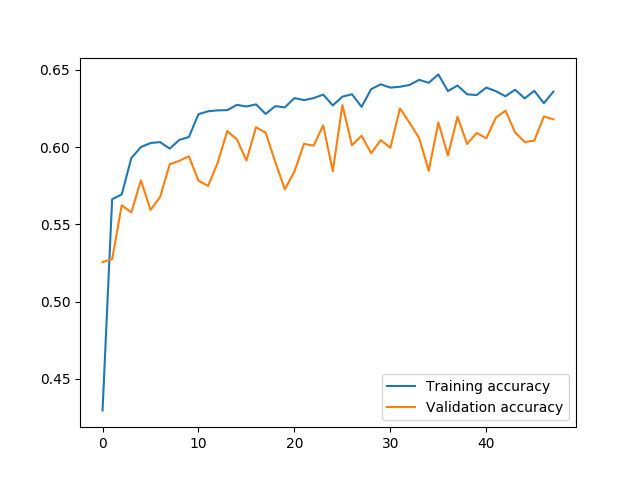

In [19]:
history = pd.DataFrame.from_dict(model.history.history)
plt.figure()

plt.plot(history['sparse_categorical_accuracy'], label='Training accuracy')
plt.plot(history['val_sparse_categorical_accuracy'], label='Validation accuracy')
plt.legend(loc='best')

In [20]:
l1 = model.get_weights()[4]

<IPython.core.display.Javascript object>


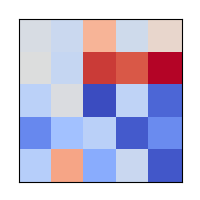

In [21]:
plt.figure(figsize=2 * np.asarray(l1.shape[2:]))

pi = 0
for f in range(l1.shape[3]):
    for c in range(l1.shape[2]):
        pi += 1
        plt.subplot(l1.shape[3], l1.shape[2], pi)
        librosa.display.specshow(l1[:, :, c, f].T)#, vmin=l1.min(), vmax=l1.max())
        
        
plt.tight_layout()

In [22]:
l2 = model.get_weights()[6].squeeze()
l2 = librosa.util.axis_sort(l2)

<IPython.core.display.Javascript object>


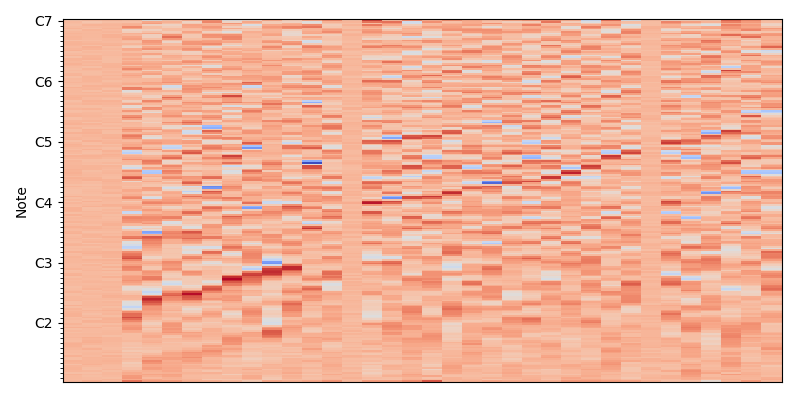

In [23]:
plt.figure(figsize=(8,4))
librosa.display.specshow(l2, y_axis='cqt_note', sr=pump.ops[0].sr, bins_per_octave=36)
plt.tight_layout()

---
# Validation viz

In [24]:
import pandas as pd
import jams

from tqdm import tqdm_notebook as tqdm

from IPython.display import Audio

import jams

import librosa

In [25]:
def score_model(pump, model, idx,
                features='/home/bmcfee/working/chords/pump',
                refs='/home/bmcfee/data/eric_chords/references_v2/'):
    
    results = {}
    for item in tqdm(idx.index):
        jam = jams.load('{}/{}.jams'.format(refs, item), validate=False)
        datum = np.load('{}/{}.npz'.format(features, item))['cqt/mag']
        
        ann = pump.ops[1].inverse(model.predict(datum)[0])
        results[item] = jams.eval.chord(jam.annotations['chord', 0], ann)
        
    return pd.DataFrame.from_dict(results, orient='index')

In [26]:
df = score_model(pump, model, idx_test)

In [27]:
dfr = df[['thirds', 'triads', 'tetrads', 'root', 'mirex', 'majmin', 'sevenths']]

In [28]:
dfr.describe()

,thirds,triads,tetrads,root,mirex,majmin,sevenths
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.772300,0.729748,0.589129,0.806987,0.788497,0.785096,0.646118
std,0.148328,0.189070,0.203291,0.118855,0.140169,0.154517,0.189233
min,0.074984,0.039769,0.024978,0.099309,0.072262,0.072262,0.024978
25%,0.704841,0.636315,0.466297,0.742035,0.734978,0.727577,0.539258
50%,0.805573,0.778919,0.614245,0.828047,0.815798,0.812942,0.693661
75%,0.880851,0.866131,0.732395,0.892318,0.884311,0.898266,0.769953
max,0.985322,0.985322,0.917291,0.985322,0.985322,0.985322,0.960053


In [111]:
dfr.describe()

,thirds,triads,tetrads,root,mirex,majmin,sevenths
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.766501,0.727001,0.582575,0.805127,0.793788,0.780656,0.636473
std,0.150797,0.188267,0.214849,0.120718,0.136653,0.153669,0.203488
min,0.077030,0.035399,0.009879,0.096665,0.094359,0.064323,0.018820
25%,0.693837,0.641354,0.443133,0.745414,0.727854,0.705884,0.524820
50%,0.792074,0.770722,0.626143,0.828113,0.824786,0.811991,0.684789
75%,0.883529,0.858151,0.744555,0.885459,0.889261,0.890280,0.780201
max,0.984445,0.984445,0.920421,0.984445,0.984445,0.984445,0.979995


In [40]:
dfr.describe()

,thirds,triads,tetrads,root,mirex,majmin,sevenths
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.769563,0.727529,0.590000,0.804221,0.794089,0.783547,0.646078
std,0.148312,0.187265,0.202314,0.120829,0.136100,0.154343,0.189277
min,0.049119,0.034102,0.026934,0.060540,0.049119,0.050010,0.026934
25%,0.680561,0.636185,0.463364,0.734355,0.735562,0.709487,0.541688
50%,0.798823,0.777461,0.610777,0.828335,0.815728,0.818413,0.686474
75%,0.882994,0.862762,0.739739,0.901487,0.883233,0.902220,0.785684
max,0.991141,0.991141,0.916893,0.991141,0.991141,0.991141,0.964697


<IPython.core.display.Javascript object>


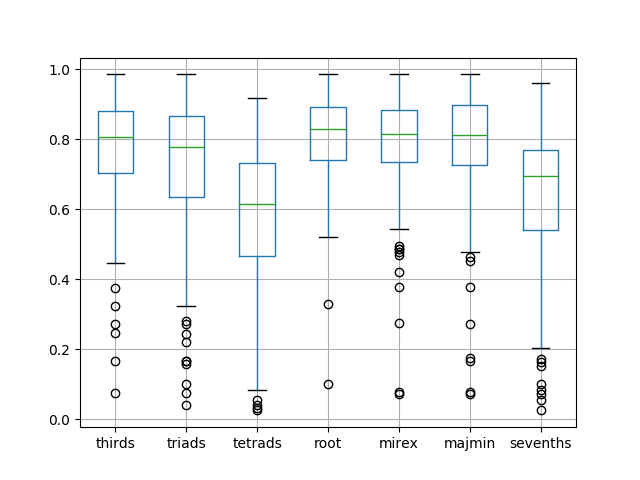

In [29]:
plt.figure()
dfr.boxplot();

<IPython.core.display.Javascript object>


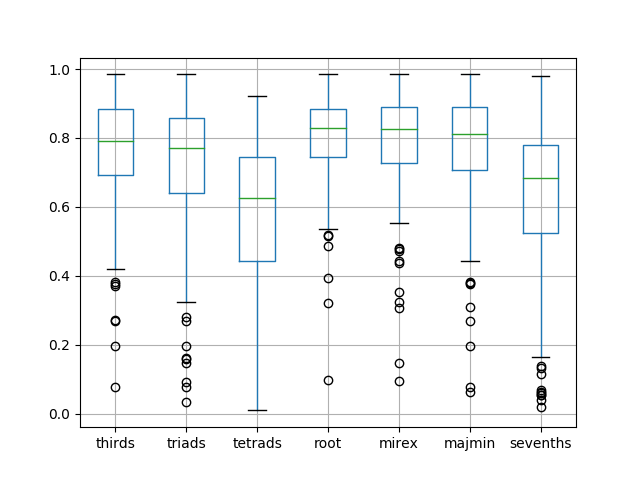

In [112]:
plt.figure()
dfr.boxplot();

<IPython.core.display.Javascript object>


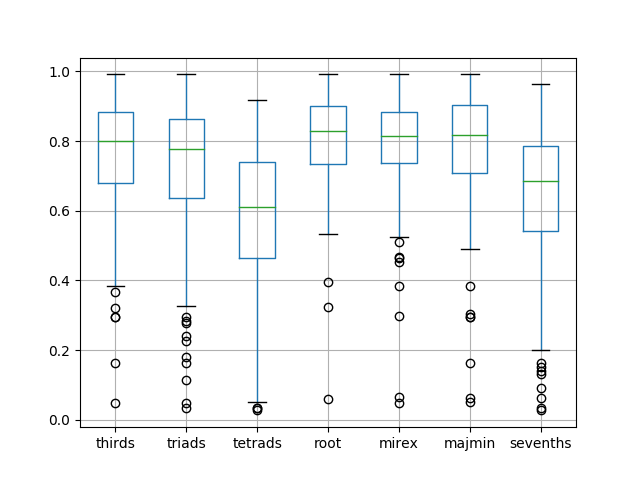

In [41]:
plt.figure()
dfr.boxplot();

In [30]:
dfr.describe().loc['mean']

thirds      0.772300
triads      0.729748
tetrads     0.589129
root        0.806987
mirex       0.788497
majmin      0.785096
sevenths    0.646118
Name: mean, dtype: float64

In [113]:
dfr.describe().loc['mean']

thirds      0.766501
triads      0.727001
tetrads     0.582575
root        0.805127
mirex       0.793788
majmin      0.780656
sevenths    0.636473
Name: mean, dtype: float64

In [42]:
dfr.describe().loc['mean']

thirds      0.769563
triads      0.727529
tetrads     0.590000
root        0.804221
mirex       0.794089
majmin      0.783547
sevenths    0.646078
Name: mean, dtype: float64

In [43]:
F = idx_val.index[99]

In [71]:
F = df['mirex'].argmin()

In [72]:
F

'TRWMAJH127F8F16AFF'

In [73]:
datum = np.load('/home/bmcfee/working/chords/pump/{}.npz'.format(F))

In [74]:
J = jams.load('/home/bmcfee/data/eric_chords/references_v2/{}.jams'.format(F))

In [75]:
ann_true = pump['chord_tag'].inverse(datum['chord_tag/chord'][0])

In [76]:
ann = pump['chord_tag'].inverse(model.predict(datum['cqt/mag'])[0])

In [77]:
pd.DataFrame.from_records([jams.eval.chord(J.annotations['chord', 0], ann)]).loc[0]

thirds          0.324287
thirds_inv      0.323067
triads          0.039769
triads_inv      0.039769
tetrads         0.039769
tetrads_inv     0.039769
root            0.329013
mirex           0.072262
majmin          0.072262
majmin_inv      0.072262
sevenths        0.072262
sevenths_inv    0.072262
Name: 0, dtype: float64

<IPython.core.display.Javascript object>


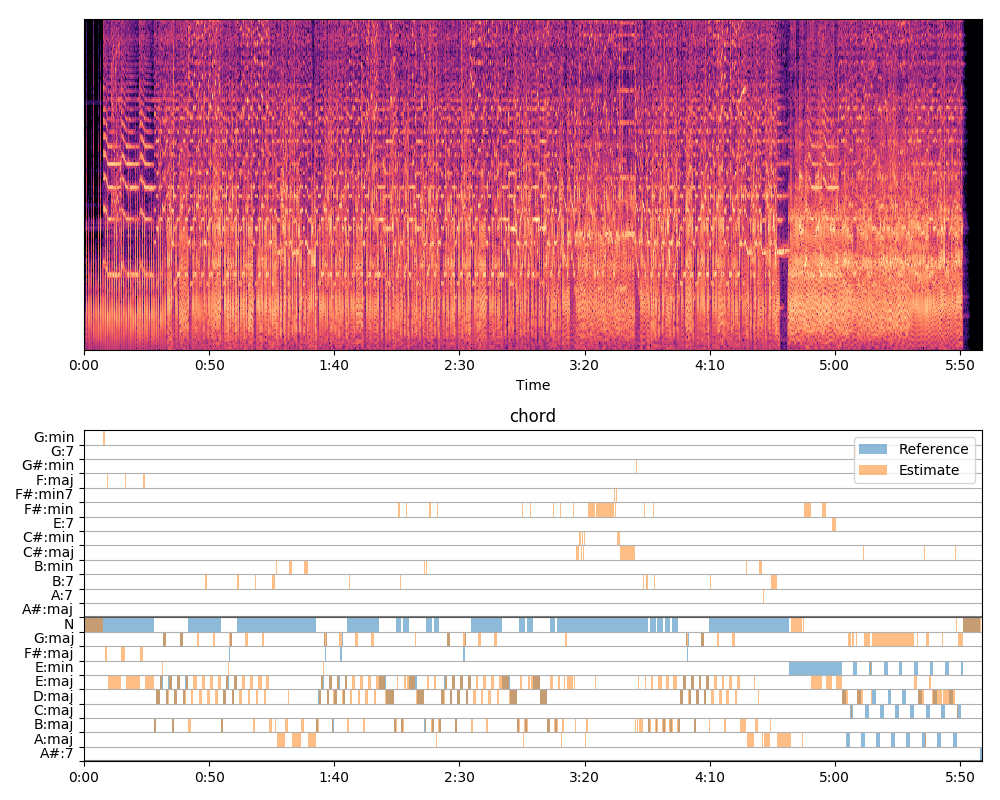

In [78]:
plt.figure(figsize=(10, 8))

ax = plt.subplot(2,1,1)
librosa.display.specshow(datum['cqt/mag'][0, :, :, 0].T,
                         sr=pump.ops[0].sr,
                         hop_length=pump.ops[0].hop_length,
                         x_axis='time')

plt.subplot(2,1,2, sharex=ax)
jams.display.display(ann_true, meta=False, label='Reference', alpha=0.5)
jams.display.display(ann, meta=False, label='Estimate', alpha=0.5)
plt.legend()
plt.tight_layout()

In [79]:
Audio(filename='/home/bmcfee/data/eric_chords/audio/{}.mp3'.format(F))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
y, sr = librosa.load('/home/bmcfee/data/eric_chords/audio/{}.mp3'.format(F), sr=8000)

In [ ]:
Audio(data=np.vstack([y, jams.sonify.sonify(ann, sr=sr, duration=int(np.ceil(len(y) / sr)))[:len(y)]]),
      rate=sr)